In [69]:
import concurrent
import os.path
import time
import timeit
from typing import Callable, Mapping, Dict, List
import logging
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , fbeta_score
import math
import tqdm
import numpy as np
import itertools
import pickle
import os
import pygad
import numexpr
from collections import OrderedDict
import seaborn as sns
from scipy import signal
from scipy import stats

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

plt.rcParams['figure.figsize'] = [15, 10]

#a = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")


### Kaggle dataset

In [70]:
test = pd.read_csv("snp500.csv")

In [71]:
test.loc[test["Open"] == test["Close"]]

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000
...,...,...,...,...,...,...,...
11326,1995-01-12,461.64,461.93,460.63,461.64,461.64,313040000
11843,1997-01-28,765.02,776.32,761.75,765.02,765.02,541580000
14206,2006-06-20,1240.12,1249.01,1238.87,1240.12,1240.12,2232950000
15291,2010-10-11,1165.32,1168.68,1162.02,1165.32,1165.32,2505900000


In [72]:
test['date'] = pd.to_datetime(test['Date'])

računanje točk obrata trenda

In [73]:
# rewriting trendReversal because i think i made it incorrectly
def trend_reversal_min_max(opens: pd.Series, percent: float) -> list:
    """
    Calculate trend reversal points based on percent
    :param opens: pandas series of stock open prices
    :param percent: percent of reversal to consider a point a pivot
    :return: list of pivots
    """
    min_p = max_p = opens.iloc[0]
    idx_min = idx_max = 0
    init_all = True
    pivots = []

    for idx, val in opens.items():
        # we have found a new maximum
        if init_all:
            if val >= max_p:
                max_p = val
                idx_max = idx
            if val <= min_p:
                min_p = val
                idx_min = idx
            if abs(max_p - min_p)/min_p >= percent:
                init_all = False
                # first pivot was a minimum
                if idx_min < idx_max:
                    pivots.append(idx_min)
                    max_last_added = False
                # first pivot was a maximum
                else:
                    pivots.append(idx_max)
                    max_last_added = True
        else:
            if max_last_added:
                # we have to reset max_p because a new trough has been reached
                if min_p >= val:
                    min_p = val
                    max_p = val
                    idx_min = idx
                    idx_max = idx
                # we are searching for the start of an uptrend
                if max_p <= val:
                    max_p = val
                    idx_max = idx
                # we have come percent% away from minimum so that means that is a valid minimum we reset max_p and min_p to current point and start looking for maximum
                if abs(max_p - min_p)/min_p >= percent:
                    pivots.append(idx_min)
                    max_last_added = False
                    min_p = val
                    max_p = val
                    idx_min = idx
                    idx_max = idx
            else:
                if max_p <= val:
                    min_p = val
                    max_p = val
                    idx_min = idx
                    idx_max = idx
                if min_p >= val:
                    min_p = val
                    idx_min = idx
                if abs(max_p - min_p)/min_p >= percent:
                    pivots.append(idx_max)
                    max_last_added = True
                    min_p = val
                    max_p = val
                    idx_min = idx
                    idx_max = idx
    return pivots


In [74]:

a = trend_reversal_min_max(test["Close"].iloc[1:],0.10)
for_visualisation = test.iloc[1:]
#minmax normalization
vol = (test["Volume"]-test["Volume"].min())/(test["Volume"].max()-test["Volume"].min())
percentvol = vol*100
convolved = (test['Volume']-test['Volume'].shift(1))/test['Volume'].shift(1)
convolved = convolved[1:]
#bad because there is alot of days where the price didn't even move during the day
#convolved_price = (test['Close']-test['Close'])/test['Close']
#convolved_price = convolved_price[1:]
convolved_price = (test['Close']-test['Close'].shift(1))/test['Close'].shift(1)
convolved_price = convolved_price[1:]
print(convolved.std(),len(for_visualisation))
"""
plt.plot(range(len(test.index)),test["Open"])
plt.plot(a,test["Open"].iloc[a])
plt.yscale("log")
plt.show()
"""

0.2880866584698175 17542


'\nplt.plot(range(len(test.index)),test["Open"])\nplt.plot(a,test["Open"].iloc[a])\nplt.yscale("log")\nplt.show()\n'

Show points at which volume change is abnormal(1 std deviation below or above mean)

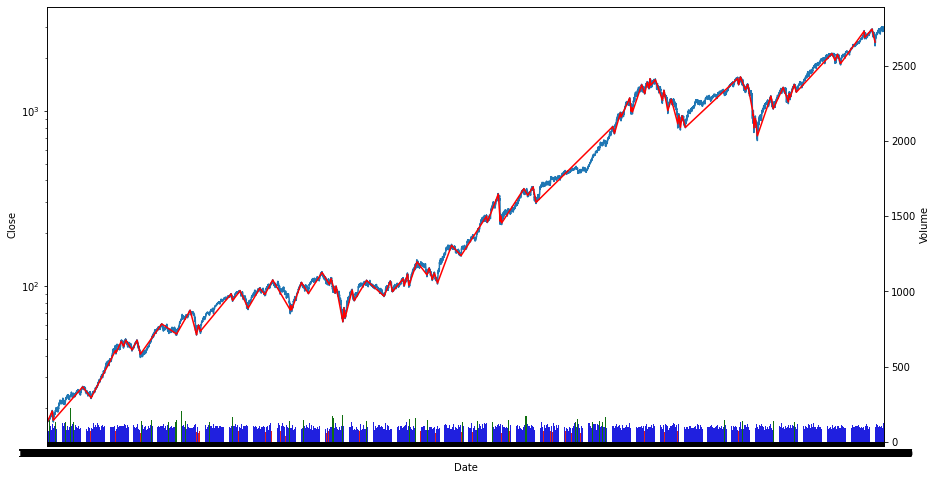

In [75]:
#print(a)
plt.figure(figsize=(15,8))
above = convolved>convolved.mean() + convolved.std()
below = convolved<convolved.mean() - convolved.std()
palette = ["green" if up else "red" if down else "blue" for up,down in zip(above,below)]
ax = sns.lineplot(data = for_visualisation,x="Date",y='Close')
ax.set(yscale='log')
ax2 = ax.twinx()
sns.lineplot(y = for_visualisation['Close'].iloc[a],x=for_visualisation["Date"].iloc[a],ax = ax, color='red' )
#sns.lineplot()
sns.barplot(data=for_visualisation,y = convolved*100 + 100, x="Date",ax =ax2,palette=palette)
#sns.barplot(data = for_visualisation["Volume"],ax=ax2)
plt.show()

Return vs Volume Change

/tmp/ipykernel_2035427/1555402801.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data = for_visualisation,x="Date",y=convolved_price*10+10,palette=price_p)


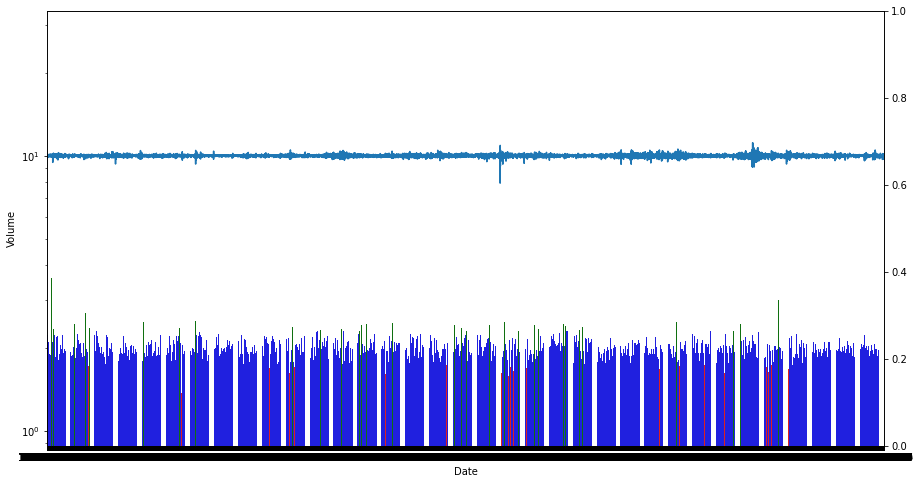

In [76]:
above = convolved>convolved.mean() + convolved.std()
below = convolved<convolved.mean() - convolved.std()
vol_p = ["green" if up else "red" if down else "blue" for up,down in zip(above,below)]

above = convolved_price>convolved_price.mean() + convolved_price.std()
below = convolved_price<convolved_price.mean() - convolved_price.std()
price_p = ["green" if up else "red" if down else "blue" for up,down in zip(above,below)]

plt.figure(figsize=(15,8))
ax = sns.lineplot(data = for_visualisation,x="Date",y=convolved_price*10+10,palette=price_p)
ax.set(yscale='log')
ax2 = ax.twinx()
#sns.lineplot(y = for_visualisation['Close'].iloc[a],x=for_visualisation["Date"].iloc[a],ax = ax, color='red' )
#sns.lineplot()
sns.barplot(data=for_visualisation,y = convolved + 2, x="Date",ax =ax,palette=vol_p)
#sns.barplot(data = for_visualisation["Volume"],ax=ax2)
plt.show()

Volume sliding window

In [110]:
def window_operation(cutout):
    cutout.mean()
    return 1


wind = test['Close'].rolling(window=5)
wind.apply(window_operation)

TypeError: must be real number, not tuple

Volume to price ratio

<Figure size 1080x576 with 0 Axes>

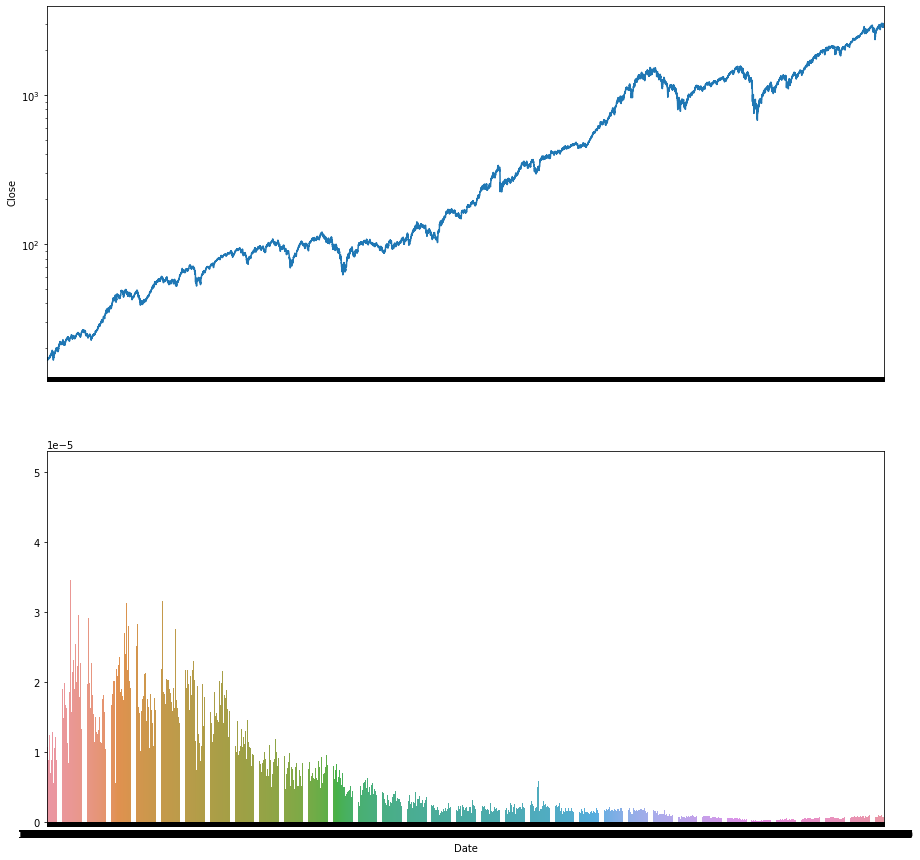

In [78]:
plt.figure(figsize=(15,8))
fig,axs = plt.subplots(2,1,sharex=True,figsize=(15,15))
ax = sns.lineplot(x = test["Date"],y = test['Close'],ax=axs[0],estimator=None)
ax.set(yscale='log')
sns.barplot(x= test["Date"],y = test['Close']/test["Volume"],ax = axs[1])
plt.show()

Volume change to price change ratio

In [79]:
#helper functions

#needed because of some massive outliers
def median_of_absolute_error_from_median(series: pd.Series) -> float:
    """
    the name is self explanatory
    :param series: series of which you want to calculate the metric
    :return: metric
    """
    median = series.median()
    absolute_error = (median - series).abs()
    return absolute_error.median()


def nth_percent_from_median(series: pd.Series, n: float) -> float:
    median = series.median()
    absolute_error = (median - series).abs()
    absolute_error.arg_sort
    idx = math.round(len(series) * n)
    return

In [80]:
ratioed = convolved_price/convolved
m_pos = ratioed != np.inf
m_neg = ratioed != -np.inf
max_non_inf = ratioed[m_pos].max()
min_non_inf = ratioed[m_neg].min()
ratioed = ratioed.replace(np.inf,max_non_inf)
ratioed = ratioed.replace(-np.inf,min_non_inf)
std = ratioed.std()
mean = ratioed.mean()
ratioed.clip(lower = ratioed.quantile(0.005), upper = ratioed.quantile(0.995), inplace = True)
#print(,)

In [81]:

print(median_of_absolute_error_from_median(ratioed))

0.04562105682530401


<AxesSubplot:ylabel='Count'>

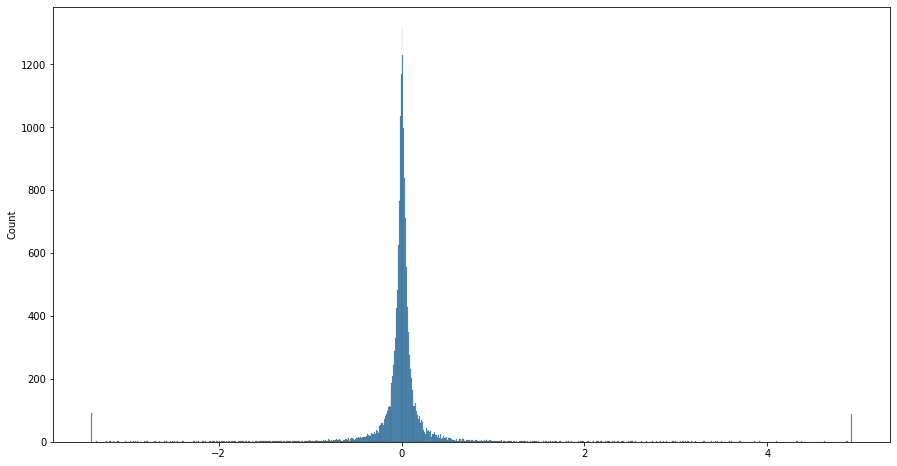

In [82]:
#plt.figure(figsize=(8,8))
fig,ax = plt.subplots(figsize=(15,8))
sns.histplot(x=ratioed,binwidth=0.01,ax=ax)

Plot of Volume change to price ratio

In [106]:
SLICE = range(10000,13000)

#point filter calculation
point_idxs_upper = ratioed.iloc[SLICE][ratioed.iloc[SLICE] > ratioed.quantile(0.99)].index
point_idxs_lower = ratioed.iloc[SLICE][ratioed.iloc[SLICE] < ratioed.quantile(0.01)].index

/tmp/ipykernel_2035427/3300339533.py:6: UserWarning: 
The palette list has fewer values (24) than needed (32) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x = for_visualisation["Date"].iloc[point_idxs_lower], y = for_visualisation['Close'].iloc[point_idxs_lower], hue=for_visualisation["Date"].iloc[point_idxs_lower], palette = ["red"]*len(point_idxs_upper), ax = ax)


<Figure size 1440x576 with 0 Axes>

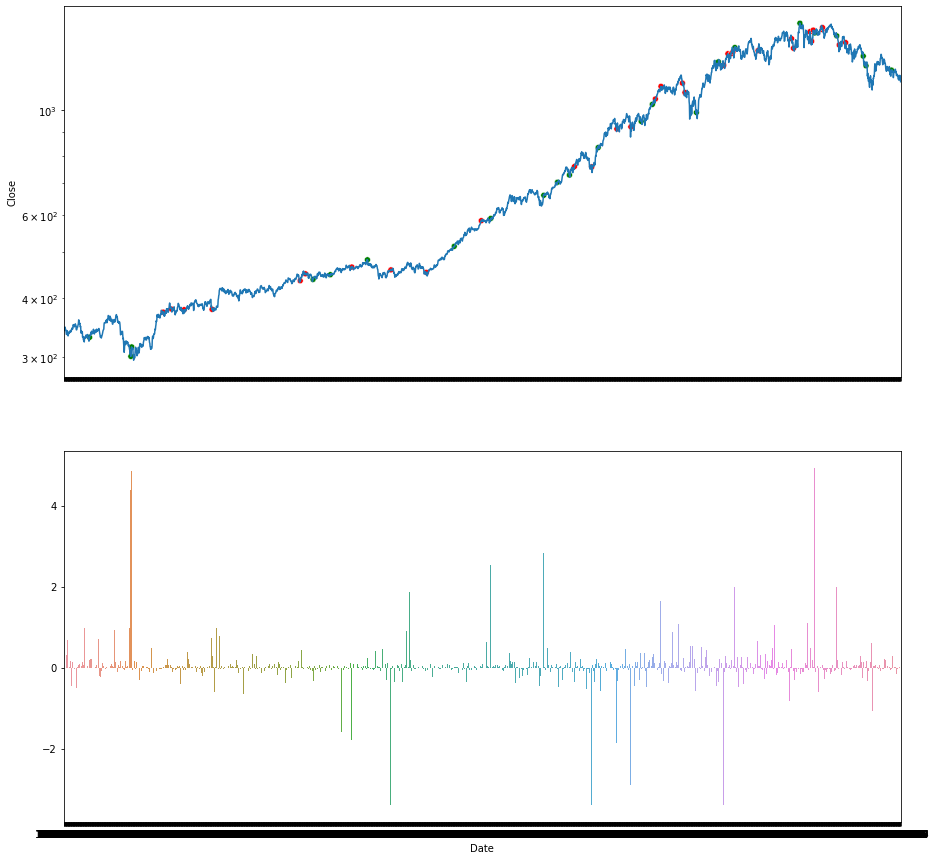

In [107]:
plt.figure(figsize=(20,8))
fig,axs = plt.subplots(2,1,sharex=True,figsize=(15,15))
ax = sns.lineplot(x = for_visualisation["Date"].iloc[SLICE],y = for_visualisation['Close'].iloc[SLICE],ax=axs[0],estimator=None,n_boot=0)
ax.set(yscale='log')
g = sns.scatterplot(x = for_visualisation["Date"].iloc[point_idxs_upper], y = for_visualisation['Close'].iloc[point_idxs_upper], hue=for_visualisation["Date"].iloc[point_idxs_upper], palette = ["green"]*len(point_idxs_upper), ax = ax)
sns.scatterplot(x = for_visualisation["Date"].iloc[point_idxs_lower], y = for_visualisation['Close'].iloc[point_idxs_lower], hue=for_visualisation["Date"].iloc[point_idxs_lower], palette = ["red"]*len(point_idxs_upper), ax = ax)
g.legend_.remove()
sns.barplot(x= for_visualisation["Date"].iloc[SLICE],y = ratioed.iloc[SLICE],ax = axs[1])
plt.show()

Damo v bool array za AUC racunat

In [11]:
def find_intersect_2_ordered_lists(list1,list2):
    li2=li1=0
    intersect = []
    if list1 is None or list2 is None or len(list1) == 0 or len(list2)==0 :
        return []
    while True:
        if list1[li1] == list2[li2]:
            intersect.append(list1[li1])
            li1 = li1 + 1
            li2 = li2 + 1
        elif list1[li1] < list2[li2]:
            li1 = li1 + 1
        else:
            li2 = li2 + 1
        if li1 == len(list1) or li2 == len(list2):
            return intersect

def all_true(truers):
    ret = True
    for j in truers:
        if not j:
            return False
    return True

def combine_lists(lists):
    idxs = [0 for l in lists]
    lens = [len(l) for l in lists]
    comb = []
    while True:
        if all_true([l == k for (l,k) in zip(idxs,lens)]):
            return comb
        cur = idxs.index(min(idxs))


In [ ]:
def simpleAUC(solution, index):
    global metric, df, dfY, tick, percent


    #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
    if solution[0] <= -1 or solution[1] <= -1  or solution[4] < 0 or solution[5] < 0 : #or solution[2] <= -1 or solution[3] <= -1 or solution[6] < 0 or solution[7] < 0
        return -10000000000
    retFUp = solution[0]
    volFUp = solution[1]
    #retFDown = solution[2]
    #volFDown = solution[3]
    fit = 0
    lfRUp = list(df[tick][0][df[tick][0]["return"]>retFUp].index + math.floor(solution[4]))
    #lfRDw = list(df[tick][0][df[tick][0]["return"]>retFDown].index + math.floor(solution[6]))
    lfVUp = list(df[tick][0][df[tick][0]["volume%"]>volFUp].index + math.floor(solution[5]))
    #lfVDw = list(df[tick][0][df[tick][0]["volume%"]>volFDown].index + math.floor(solution[7]))



    res= pd.DataFrame(data=[False]*len(df[tick][0]))
    up = list(find_intersect_2_ordered_lists(lfVUp,lfRUp))
    cut = 0
    for k in reversed(up):
        if k < len(df[tick][0]):
            break
        else:
            cut = cut+1
    if cut > 0:
        up = up[:-cut]
    #down = #list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
    cut = 0

    if cut > 0:
        #down = down[:-cut]
    if up is not None :
        res.iloc[up] = True
    #if down is not None :
        #res.iloc[down] = True
    #print(roc_auc_score(dfY[tick][percent][0],res))
    return roc_auc_score(dfY[tick][percent][0],res)

In [18]:
def fit_params_AUC(df,dfY,tick,percent):

    def fit_me_AUC(solution, index):
        #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
        if solution[0] <= -1 or solution[1] <= -1 or solution[2] <= -1 or solution[3] <= -1 or solution[4] < 0 or solution[5] < 0 or solution[6] < 0 or solution[7] < 0:
            return -10000000000
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[2]
        volFDown = solution[3]
        fit = 0
        lfRUp = list(df[tick][0][df[tick][0]["return"]>retFUp].index + math.floor(solution[4]))
        lfRDw = list(df[tick][0][df[tick][0]["return"]>retFDown].index + math.floor(solution[6]))
        lfVUp = list(df[tick][0][df[tick][0]["volume%"]>volFUp].index + math.floor(solution[5]))
        lfVDw = list(df[tick][0][df[tick][0]["volume%"]>volFDown].index + math.floor(solution[7]))



        res= pd.DataFrame(data=[False]*len(df[tick][0]))
        up = list(find_intersect_2_ordered_lists(lfVUp,lfRUp))
        cut = 0
        for k in reversed(up):
            if k < len(df[tick][0]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][0]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][0],res)
    return fit_me_AUC

In [19]:
def fit_params_AUC_lagged(df,dfY,tick,percent,n_lagged = 1):
    def fita(solution, index):
        #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
        if solution[0] <= -1 or solution[1] <= -1 or solution[2] <= -1 or solution[3] <= -1 or solution[4] < 0 or solution[5] < 0 or solution[6] < 0 or solution[7] < 0:
            return -10000000000
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[2]
        volFDown = solution[3]
        fit = 0
        lfRUp = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:]["return"]>retFUp].index + math.floor(solution[4]))
        lfRDw = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:]["return"]>retFDown].index + math.floor(solution[6]))
        lfVUp = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:][col]>volFUp].index + math.floor(solution[5]))
        lfVDw = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:][col]>volFDown].index + math.floor(solution[7]))



        res= pd.DataFrame(data=[False]*len(df[tick][0][n_lagged-1:]))
        up = list(find_intersect_2_ordered_lists(lfVUp,lfRUp))
        cut = 0
        for k in reversed(up):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][0][n_lagged-1:],res)
    return fita

In [20]:
def fit_params_AUC_lagged_combinedOR(df,dfY,tick,percent,n_lagged = 20):
    def fita(solution, index):
        #24 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW]
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[6]
        volFDown = solution[7]
        fit = 0
        l_UP = []
        l_DW = []
        buildingblocksUP = []
        buildingblocksDW = []
        test = df[tick][0][n_lagged-1:]
        up = test.loc[(test['return'].shift(math.floor(solution[12])) > solution[0]) |
                      (test['volume%'].shift(math.floor(solution[13])) > solution[1]) |
                       (test['volume5%'].shift(math.floor(solution[14])) > solution[2]) |
                        (test['volume10%'].shift(math.floor(solution[15])) > solution[3]) |
                         (test['volume15%'].shift(math.floor(solution[16])) > solution[4]) |
                          (test['volume20%'].shift(math.floor(solution[17])) > solution[5])
                        ].index
        down = test.loc[(test['return'].shift(math.floor(solution[18])) > solution[6]) |
        (test['volume%'].shift(math.floor(solution[19])) > solution[7]) |
        (test['volume5%'].shift(math.floor(solution[20])) > solution[8]) |
        (test['volume10%'].shift(math.floor(solution[21])) > solution[9]) |
        (test['volume15%'].shift(math.floor(solution[22])) > solution[10]) |
        (test['volume20%'].shift(math.floor(solution[23])) > solution[11])
                        ].index


        res= pd.DataFrame(data=[False]*len(df[tick][0][n_lagged-1:]))

        cut = 0
        for k in reversed(up):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        #down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][0][n_lagged-1:],res)
    return fita

In [21]:
def fit_params_AUC_lagged_combinedOR_test(df,dfY,tick,percent,n_lagged = 20):
    def fita(solution, index):
        #24 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW]
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[6]
        volFDown = solution[7]
        fit = 0
        l_UP = []
        l_DW = []
        buildingblocksUP = []
        buildingblocksDW = []
        test = df[tick][1][n_lagged-1:]
        up = test.loc[(test['return'].shift(math.floor(solution[12])) > solution[0]) |
                      (test['volume%'].shift(math.floor(solution[13])) > solution[1]) |
                       (test['volume5%'].shift(math.floor(solution[14])) > solution[2]) |
                        (test['volume10%'].shift(math.floor(solution[15])) > solution[3]) |
                         (test['volume15%'].shift(math.floor(solution[16])) > solution[4]) |
                          (test['volume20%'].shift(math.floor(solution[17])) > solution[5])
                        ].index
        down = test.loc[(test['return'].shift(math.floor(solution[18])) > solution[6]) |
        (test['volume%'].shift(math.floor(solution[19])) > solution[7]) |
        (test['volume5%'].shift(math.floor(solution[20])) > solution[8]) |
        (test['volume10%'].shift(math.floor(solution[21])) > solution[9]) |
        (test['volume15%'].shift(math.floor(solution[22])) > solution[10]) |
        (test['volume20%'].shift(math.floor(solution[23])) > solution[11])
                        ].index


        res= pd.DataFrame(data=[False]*len(df[tick][1][n_lagged-1:]))

        cut = 0
        for k in reversed(up):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        #down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

In [22]:
def fit_me10_all(solution,index):
    #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
    if solution[0] <= -1 or solution[1] <= -1 or solution[2] <= -1 or solution[3] <= -1 or solution[4] < 0 or solution[5] < 0 or solution[6] < 0 or solution[7] < 0:
        return -10000000000
    #dodal bomo še kako se filtre združuje skupi z or ali and!

    retFUp = solution[0]
    volFUp = solution[1]
    retFDown = solution[2]
    volFDown = solution[3]
    fit = 0
    #print(solution.dtype)
    #nima smisla da je en pred pivotom za vrh manjši kot za dolino saj more bit return change negativen za dolino in pozitiven za vrh
    if retFUp<= retFDown:
        return -10000000000
    for tick in splits25:
        #ret filter
        #lahko še naredimo da je variable kolk prej rab se zgodit filter

        lfRUp = list(splits25[tick][0][splits25[tick][0]["return"]>retFUp].index + math.floor(solution[4]))
        lfRDw = list(splits25[tick][0][splits25[tick][0]["return"]>retFDown].index + math.floor(solution[6]))
        lfVUp = list(splits25[tick][0][splits25[tick][0]["volume%"]>volFUp].index + math.floor(solution[5]))
        lfVDw = list(splits25[tick][0][splits25[tick][0]["volume%"]>volFDown].index + math.floor(solution[7]))
        #print(len(lfRUp),len(lfRDw),len(lfVUp),len(lfVDw))
        up = set(find_intersect_2_ordered_lists(lfVUp,lfRUp))
        down = set(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        comb = list(up.union(down)).sort()


        zadetkov = len(find_intersect_2_ordered_lists(comb,ticker400_trend10[tick]))
        zgresenih = (len(comb) if comb else 0 )- zadetkov
        if comb is None:
            fit = fit -100000
        else:
            fit = fit + zadetkov - zgresenih

    return fit


In [23]:
def fit_params_AUC_lagged_combined_special(df,dfY,tick,percent,n_lagged = 20):
    def fita(solution, index):
        #24 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[6]
        volFDown = solution[7]
        fit = 0
        l_UP = []
        l_DW = []
        buildingblocksUP = []
        buildingblocksDW = []
        test = df[tick][1][n_lagged-1:]
        up = test.loc[(test['return'].shift(math.floor(solution[12])) > solution[0]) |
                      (test['volume%'].shift(math.floor(solution[13])) > solution[1]) |
                       (test['volume5%'].shift(math.floor(solution[14])) > solution[2]) |
                        (test['volume10%'].shift(math.floor(solution[15])) > solution[3]) |
                         (test['volume15%'].shift(math.floor(solution[16])) > solution[4]) |
                          (test['volume20%'].shift(math.floor(solution[17])) > solution[5])
                        ].index
        down = test.loc[(test['return'].shift(math.floor(solution[18])) > solution[6]) |
        (test['volume%'].shift(math.floor(solution[19])) > solution[7]) |
        (test['volume5%'].shift(math.floor(solution[20])) > solution[8]) |
        (test['volume10%'].shift(math.floor(solution[21])) > solution[9]) |
        (test['volume15%'].shift(math.floor(solution[22])) > solution[10]) |
        (test['volume20%'].shift(math.floor(solution[23])) > solution[11])
                        ].index


        res= pd.DataFrame(data=[False]*len(df[tick][1][n_lagged-1:]))

        cut = 0
        for k in reversed(up):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        #down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

## Ugotovitve
- zmanjšat mormo število tickerjev ker je zadeva čist prepočasna
- statičn velik preskok ne naredi velik

change the metrix so it looks for values close by:
-if its within leeway% of the pivot it should count as a hit with a bit of a penalty
-if there are multiple within leeway% of the pivot only the closest should count

In [32]:
def metric_based_on_pool(pivots: list, pivots_gd: list, opens: pd.DataFrame, leeway: float = 0.03, penalty: float = 0.01) -> float:
    """
    Calculates metric based on best close pivot to ground truth pivot
    :param pivots: pivots given by model
    :param pivots_gd: ground truth pivots
    :param opens: stocks opens history
    :param leeway: percentage allowed for pivot missing the gorund truth pivot(based of model pivot)
    :param penalty: penalty for completely missing
    :return: overall score
    """
    it = 0
    firsto = True
    best_score = 0
    overall = 0
    i = 0
    #print("pivots",len(pivots))
    #print(pivots_gd)
    #print(len(opens))
    #init pivots

    for i in range(len(pivots)):
        if pivots[i] >= pivots_gd[0]:
            # we have arrived
            break
        else:
            if leeway >= abs(opens.iloc[pivots[i]] - opens.iloc[pivots_gd[0]])/opens.iloc[pivots_gd[0]]:
                if best_score < 1 - abs(opens.iloc[i] - opens.iloc[pivots_gd[0]])/opens.iloc[pivots_gd[0]]:
                    best_score = 1 - abs(opens.iloc[i] - opens.iloc[pivots_gd[0]])/opens.iloc[pivots_gd[0]]
    
    for p in pivots[i:]:
        ##print(overall)
        try:
            if it + 1 < len(pivots_gd) and pivots_gd[it] <= p < pivots_gd[it+1]:
                # do_sth
                if leeway >= abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                    #print("uno")
                    if firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                        best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                    elif not firsto:
                        overall = overall + best_score
                        best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                        firsto = True

                elif abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]] <= leeway:
                    #print("dos")
                    if firsto:
                        overall = overall + best_score
                        best_score =  1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]
                        firsto = False
                    elif not firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]:
                        best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]
                else:
                    #print("hiya")
                    overall = overall - penalty
            elif pivots_gd[-1] <= p < len(opens):
                #print("uno12")
                # do_sth
                if abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]] <= leeway:
                    #print("uno1")
                    if leeway >= abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                        if firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                            best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                        elif not firsto:
                            overall = overall + best_score
                            best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                            firsto = True

                    elif abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p] <= leeway:
                        if firsto:
                            overall = overall + best_score
                            best_score =  1 - abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p]
                            firsto = False
                        elif not firsto and best_score < 1 - abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p]:
                            best_score = 1 - abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p]
                    else:
                        #print("hiya")
                        overall = overall - penalty
            else:
                # fix pivots

                for it in range(it,len(pivots_gd)-1):
                    #print(it)
                    if pivots_gd[it] <= p < pivots_gd[it+1]:
                        #print("yes")
                        if leeway >= abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                            #print("huh?")
                            if firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                                best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                            elif not firsto:
                                overall = overall + best_score
                                best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                                firsto = True

                        elif abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]] <= leeway:
                            #print("nuuh")
                            if firsto:
                                overall = overall + best_score
                                best_score =  1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]
                                firsto = False
                            elif not firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]:
                                best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]
                        else:
                            #print("hiya")
                            overall = overall - penalty
                        break
                    elif pivots_gd[-1] <= p < len(opens):
                        if abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]] <= leeway:

                            if leeway >= abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                                if firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                                    best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                                elif not firsto:
                                    overall = overall + best_score
                                    best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                                    firsto = True

                            elif abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p] <= leeway:
                                if firsto:
                                    overall = overall + best_score
                                    best_score =  1 - abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p]
                                    firsto = False
                                elif not firsto and best_score < 1 - abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p]:
                                    best_score = 1 - abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p]
                            else:
                                overall = overall - penalty
        except IndexError:
            print("Error: ", pivots_gd[it+1]," wew ",len(opens)-1)
    return overall

testing new metric

In [33]:
def fit_params_AUC_lagged_combined_special(df,dfY,tick,percent,n_lagged = 20,sty=0,metric=roc_auc_score, beta = -1):
    def fita(solution, index):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        test = df[tick][0][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()

        u0 = ' | ' if solution[36] else ' & '
        u1 = ' | ' if solution[37] else ' & '
        u2 = ' | ' if solution[38] else ' & '
        u3 = ' | ' if solution[39] else ' & '
        u4 = ' | ' if solution[40] else ' & '

        connec = ' | ' if solution[-1] else ' & '

        d0 = ' | ' if solution[41] else ' & '
        d1 = ' | ' if solution[42] else ' & '
        d2 = ' | ' if solution[43] else ' & '
        d3 = ' | ' if solution[44] else ' & '
        d4 = ' | ' if solution[45] else ' & '
        q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
            '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
            '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
            '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
            '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
            '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
            connec +
            '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
            '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
            '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
            '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
            '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
            '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')


        up = test.query(q).index

        res = np.array([False]*len(test))
        res[up] =True

        if beta > 0:
            return metric(dfY[tick][percent][0][n_lagged-1:],res,beta=beta)
        if beta == -1:
            return metric(up,dfY[tick][percent][0][n_lagged-1:].index[dfY[tick][percent][0][0][n_lagged-1:] == True].tolist(), opens = df[tick][0][n_lagged-1:]["open"])
        return metric(dfY[tick][percent][0][n_lagged-1:],res)
    return fita

Playing with multiproccessing


In [34]:
def one_iteration(df,dfY,percent, ticker, solution, n_lagged = 20,metric=metric_based_on_pool, beta = -1):
    metric_res = 0
    for t in ticker:
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        test = df[t][0][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()

        u0 = ' | ' if solution[36] else ' & '
        u1 = ' | ' if solution[37] else ' & '
        u2 = ' | ' if solution[38] else ' & '
        u3 = ' | ' if solution[39] else ' & '
        u4 = ' | ' if solution[40] else ' & '

        connec = ' | ' if solution[-1] else ' & '

        d0 = ' | ' if solution[41] else ' & '
        d1 = ' | ' if solution[42] else ' & '
        d2 = ' | ' if solution[43] else ' & '
        d3 = ' | ' if solution[44] else ' & '
        d4 = ' | ' if solution[45] else ' & '
        q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
            '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
            '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
            '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
            '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
            '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
            connec +
            '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
            '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
            '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
            '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
            '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
            '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')


        up = test.query(q).index

        res = np.array([False]*len(test))
        res[up] =True
        #print(len(res))
        if beta > 0:
            metric_res = metric_res + metric(dfY[t][percent][0][n_lagged-1:],res,beta=beta)
        elif beta == -1:

            #print("Hello: ",len(dfY[t][percent][0][0]),len(res))
            compareY = dfY[t][percent][0][0][n_lagged-1:]
            compareY = compareY.reset_index()
            #beta_neg = beta_neg + metric(up,compareY.index[compareY[0] == True].tolist(), opens = test["open"])
            metric_res = metric_res + metric(up,compareY.index[compareY[0] == True].tolist(), opens = test["open"])
        else:
            metric_res = metric_res + metric(dfY[t][percent][0][n_lagged-1:],res)
    return metric_res

In [35]:
#used from https://docs.python.org/3/library/itertools.html#recipes
def repeat(object, times=None):
    # repeat(10, 3) --> 10 10 10
    if times is None:
        while True:
            yield object
    else:
        for i in range(times):
            yield object

def zip_longest(*args, fillvalue=None):
    # zip_longest('ABCD', 'xy', fillvalue='-') --> Ax By C- D-
    iterators = [iter(it) for it in args]
    num_active = len(iterators)
    if not num_active:
        return
    while True:
        values = []
        for i, it in enumerate(iterators):
            try:
                value = next(it)
            except StopIteration:
                num_active -= 1
                if not num_active:
                    return
                iterators[i] = repeat(fillvalue)
                value = fillvalue
            values.append(value)
        yield tuple(values)

def grouper(iterable, n, *, incomplete='fill', fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, fillvalue='x') --> ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') --> ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') --> ABC DEF
    args = [iter(iterable)] * n
    if incomplete == 'fill':
        return zip_longest(*args, fillvalue=fillvalue)
    if incomplete == 'strict':
        return zip(*args, strict=True)
    if incomplete == 'ignore':
        return zip(*args)
    else:
        raise ValueError('Expected fill, strict, or ignore')
counter = 0
#def fit_params_AUC_lagged_combined_one_model_for(df,dfY,percent):
def fit_one_model_for(solution,index):
    global cur, df, dfY, percent, n_lagged, metric, beta
    global counter
    metric_res = 0
    executor = concurrent.futures.ProcessPoolExecutor(2)
    futures = [executor.submit(one_iteration, df,dfY,percent,t,solution)for t in grouper(df ,50, incomplete='ignore')]
    concurrent.futures.wait(futures)
    counter = counter + 1
    if counter % 300 == 0:
        print(counter//299)
        counter = counter + 30
        cur.save("for_all_model")
    return(sum(i.result() for i in futures))

#    return fita

Multiproccessing end

In [36]:
cur = None
df = splits25
dfY = splits25_YB
percent = 10
n_lagged = 20
metric = metric_based_on_pool
beta = -1

In [37]:
#def fit_params_AUC_lagged_combined_one_model(df,dfY,percent,n_lagged = 20,sty=0,metric=roc_auc_score, beta = -1):
def fit_one_model(solution, index):
    #47 genov
    #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]
    global cur, df, dfY, percent, n_lagged, metric, beta
    ####TRANSLATE TO POS ARGS####
    posu = [-1]*6
    posd = [-1]*6
    start = 0
    for i in solution[24:30]:
        if i not in posu:
            posu[start] = i
        start = start + 1
    start = 0
    for i in solution[30:36]:
        if i not in posd:
            posd[start] = i
        start = start + 1
    start = 0
    last = 0
    for i in posu:
        if i == -1:
            for last in range(last,6):
                if last not in posu:
                    posu[start] = last
                    break
        start = start + 1
    start = 0
    last = 0
    for i in posd:
        if i == -1:
            for last in range(last,6):
                if last not in posd:
                    posd[start] = last
                    break
        start = start + 1

    #############################

    for ite in range(len(solution)):
        if ite<12 and solution[ite] <= -1:
            return -1
        elif ite>=12 and solution[ite] < 0:
            return -1
    solution = [x[0] if hasattr(x,'__len__') else x for x in solution]

    col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
    u0 = ' | ' if solution[36] else ' & '
    u1 = ' | ' if solution[37] else ' & '
    u2 = ' | ' if solution[38] else ' & '
    u3 = ' | ' if solution[39] else ' & '
    u4 = ' | ' if solution[40] else ' & '

    connec = ' | ' if solution[-1] else ' & '

    d0 = ' | ' if solution[41] else ' & '
    d1 = ' | ' if solution[42] else ' & '
    d2 = ' | ' if solution[43] else ' & '
    d3 = ' | ' if solution[44] else ' & '
    d4 = ' | ' if solution[45] else ' & '
    q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
        '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
        '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
        '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
        '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
        '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
        connec +
        '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
        '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
        '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
        '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
        '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
        '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')

    res = []
    comp_res = []
    beta_neg = 0
    for t in df:

        test = df[t][0][n_lagged-1:]

        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()
        up = test.query(q).index


        if beta == -1:
            compareY = dfY[t][percent][0][0][n_lagged-1:]
            compareY = compareY.reset_index()
            beta_neg = beta_neg + metric(up,compareY.index[compareY[0] == True].tolist(), opens = test["open"])
        else:
            res_add = np.array([False]*len(test))
            res_add[up] =True
            res.append(res_add)
            comp_res.append(dfY[t][percent][0][n_lagged-1:])

    if beta > 0:
        return metric(comp_res,res,beta=beta)
    if beta == -1:
        return beta_neg
    return metric(comp_res,res)
#    return fita

In [38]:
def fit_params_AUC_lagged_combined_special_test(df,dfY,tick,percent,n_lagged = 20,sty=0,metric=roc_auc_score, beta=-1,ga=None):
    def fita(solution, index):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]


        test = df[tick][1][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()

        u0 = ' | ' if solution[36] else ' & '
        u1 = ' | ' if solution[37] else ' & '
        u2 = ' | ' if solution[38] else ' & '
        u3 = ' | ' if solution[39] else ' & '
        u4 = ' | ' if solution[40] else ' & '

        connec = ' | ' if solution[-1] else ' & '

        d0 = ' | ' if solution[41] else ' & '
        d1 = ' | ' if solution[42] else ' & '
        d2 = ' | ' if solution[43] else ' & '
        d3 = ' | ' if solution[44] else ' & '
        d4 = ' | ' if solution[45] else ' & '
        q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
            '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
            '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
            '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
            '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
            '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
            connec +
            '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
            '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
            '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
            '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
            '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
            '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')

        up = test.query(q).index
        res = np.array([False]*len(df[tick][1][n_lagged-1:]))
        res[up] =True

        #print(roc_auc_score(dfY[tick][percent][0],res))
        # positive beta is fB
        if beta > 0:
            return metric(dfY[tick][percent][1][n_lagged-1:],res,beta=beta)
        # -1 is my metric
        if beta == -1:
            reseted = dfY[tick][percent][1].reset_index()
            return metric(up,reseted[n_lagged-1:].index[dfY[tick][percent][1][0][n_lagged-1:] == True].tolist(), opens = df[tick][1][n_lagged-1:]["open"])
        # default is AUC
        return metric(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

One model for all

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30
counter = 0

cur = None
df = splits25
dfY = splits25_YB
percent = 10
n_lagged = 20
metric = metric_based_on_pool
beta = -1


if os.path.isfile('./OneMyMresults100.pkl'):
    with open('OneMyMresults100.pkl', 'rb') as handle:
        print("work")
        res_mine_one = pickle.load(handle)
else:
    res_mine_one =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}

for percent in [10]:
    q = res_mine_one.loc[(res_mine_one['Ticker'] == t)& ( res_mine_one['Percent'] ==percent),'Test_AUC']
    if len(q.index)>0 and not pd.isna(q.values[0]):
        print("huh")
        continue
    print(percent)
    gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
    with tqdm.tqdm(total=st_gen) as pbar:
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_one_model_for,sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False,parallel_processing=5)
        cur.run()
    besto = cur.best_solution(pop_fitness=None)
    res_mine_one = res_mine_one.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
    for t in ticker400_data:
        res_mine_one.loc[(res_mine_one['Ticker'] == t)& ( res_mine_one['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0,metric=fbeta_score,beta=0.5)(besto[0],0)
    res_mine_one.to_pickle('./OneMyMresults100.pkl')

In [39]:
cur = pygad.load("for_all_model")

<AxesSubplot:>

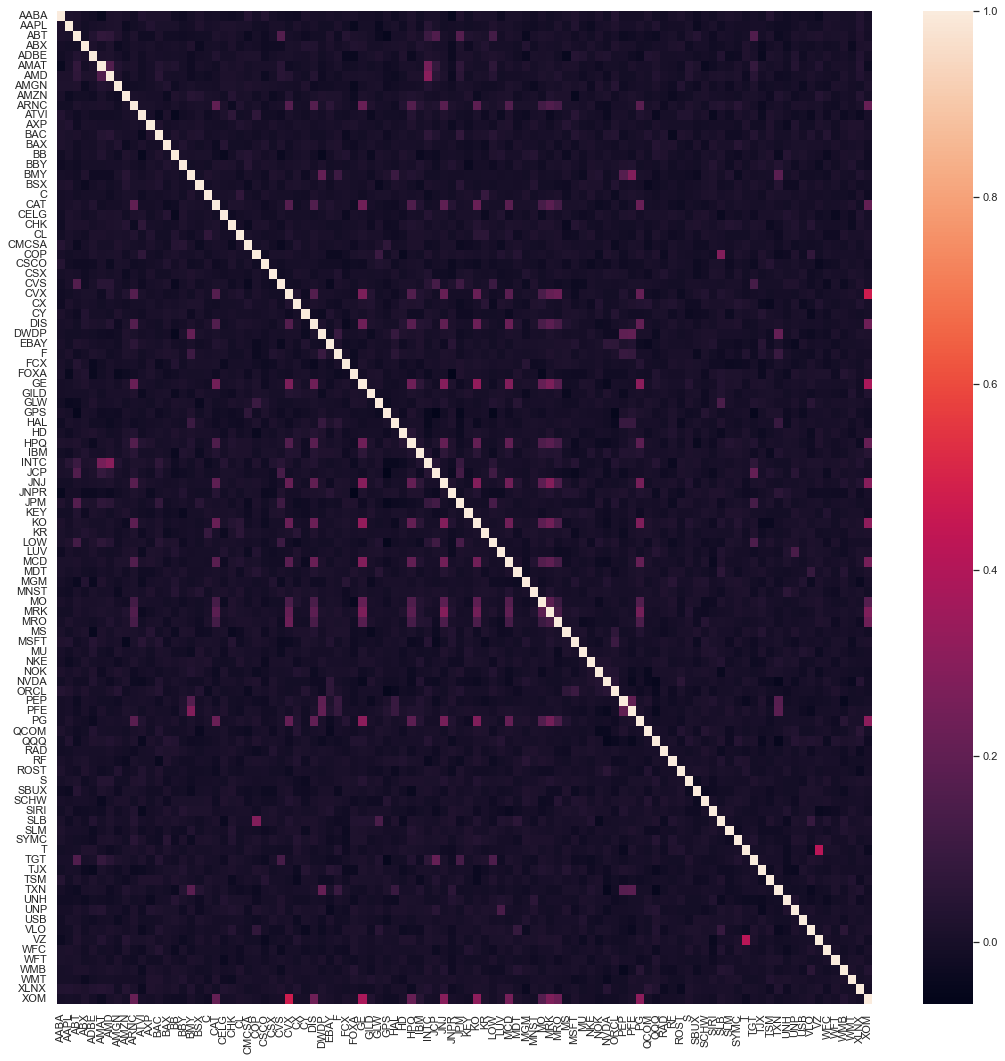

In [56]:
#plot out a correlation matrix for the stocks volume to see if its at all correlated
ticker400_vol = {x : ticker400_data[x].loc[:,"volume10%"] for x in ticker400_data}
test_corr = pd.DataFrame(ticker400_vol)
corr = test_corr.corr()

sns.set(rc={'figure.figsize':(18.27,18.27)})
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

<AxesSubplot:>

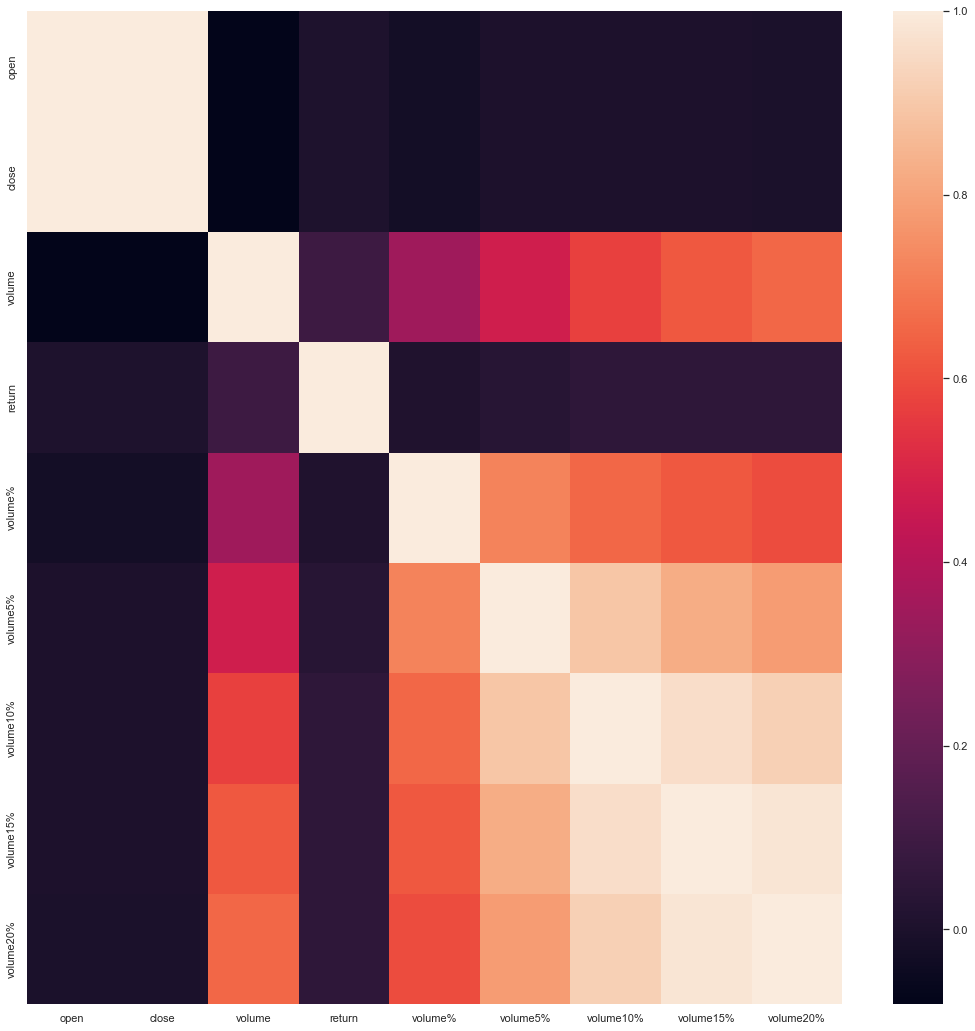

In [59]:
corr = ticker400_data["AABA"].corr()
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

My own metric

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30

if os.path.isfile('./MyMresults100.pkl'):
    with open('MyMresults100.pkl', 'rb') as handle:
        print("work")
        res_mine = pickle.load(handle)
else:
    res_mine =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}


for t in list(ticker400_data):
    print(t)
    for percent in [10]:
        q = res_mine.loc[(res_mine['Ticker'] == t)& ( res_mine['Percent'] ==percent),'Test_AUC']
        print(q)
        if len(q.index)>0 and not pd.isna(q.values[0]):
            print("huh")
            continue
        print(percent)
        gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_params_AUC_lagged_combined_special(splits25,splits25_YB,t,percent,sty=0,metric=fbeta_score,beta=0.5),sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False)
        cur.run()
        besto = cur.best_solution(pop_fitness=None)
        res_mine = res_mine.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
        res_mine.loc[(res_mine['Ticker'] == t)& ( res_mine['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0,metric=fbeta_score,beta=0.5)(besto[0],0)
        res_mine.to_pickle('./MyMresults100.pkl')

[on impact of skewness on metrics](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4285355/)
testing other metrics on AABA:
f0.5

In [ ]:
gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30

if os.path.isfile('./F05results100.pkl'):
    with open('F05results100.pkl', 'rb') as handle:
        print("work")
        res_f05 = pickle.load(handle)
else:
    res_f05 =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}


t = 'AABA'
percent = 15
for t in list(ticker400_data):
    print(t)
    for percent in [10]:
        q = res_f05.loc[(res_f05['Ticker'] == t)& ( res_f05['Percent'] ==percent),'Test_AUC']
        print(q)
        if len(q.index)>0 and not pd.isna(q.values[0]):
            print("huh")
            continue
        print(percent)
        gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_params_AUC_lagged_combined_special(splits25,splits25_YB,t,percent,sty=0,metric=fbeta_score,beta=0.5),sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False)
        cur.run()
        besto = cur.best_solution(pop_fitness=None)
        res_f05 = res_f05.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
        res_f05.loc[(res_f05['Ticker'] == t)& ( res_f05['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0,metric=fbeta_score,beta=0.5)(besto[0],0)
        res_f05.to_pickle('./F05results100.pkl')

AUC

In [ ]:
gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30

if os.path.isfile('./AUCresults100.pkl'):
    with open('AUCresults100.pkl', 'rb') as handle:
        print("work")
        res_auc = pickle.load(handle)
else:
    res_auc =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}


t = 'AABA'
percent = 15
for t in list(ticker400_data):
    print(t)
    for percent in [10]:
        q = res_auc.loc[(res_auc['Ticker'] == t)& ( res_auc['Percent'] ==percent),'Test_AUC']
        print(q)
        if len(q.index)>0 and not pd.isna(q.values[0]):
            print("huh")
            continue
        print(percent)
        gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_params_AUC_lagged_combined_special(splits25,splits25_YB,t,percent,sty=0),sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False)
        cur.run()
        besto = cur.best_solution(pop_fitness=None)
        res_auc = res_auc.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
        res_auc.loc[(res_auc['Ticker'] == t)& ( res_auc['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0)(besto[0],0)
        res.to_pickle('./AUCresults100.pkl')

In [ ]:
"""pd.options.mode.chained_assignment = None  # default='warn'

gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30


if os.path.isfile('./results100.pkl'):
    with open('results100.pkl', 'rb') as handle:
        print("work")
        res = pickle.load(handle)
else:
    res =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}


for t in list(ticker400_data):
    print(t)
    for percent in [10,15,20]:
        q = res.loc[(res['Ticker'] == t)& ( res['Percent'] ==percent),'Test_AUC']
        print(q)
        if len(q.index)>0 and not pd.isna(q.values[0]):
            print("huh")
            continue
        print(percent)
        gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_params_AUC_lagged_combined_special(splits25,splits25_YB,t,percent,sty=0),sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False)
        cur.run()
        besto = cur.best_solution(pop_fitness=None)
        res = res.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
        res.loc[(res['Ticker'] == t)& ( res['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0)(besto[0],0)
        res.to_pickle('./results100.pkl')"""

In [ ]:
duration = 4  # seconds
freq = 440  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))




In [ ]:
https://i.redd.it/7erxyzfox6s91.jpg

In [ ]:
#res.set_index(['Ticker','Percent'],inplace=True)

In [ ]:
#len(res_f05.loc[res_f05['Percent'] == 10])
fix, ax = plt.subplots(2,3,figsize=(15,10))
bins = np.arange(0,1,0.001)
r = 0
c = 0
for s in ['Train_AUC','Test_AUC']:
    for i in [10]:
        #print(hist(res_f05.loc[res_f05['Percent'] == i][s])
        ax[r,c].hist(res_f05.loc[res_f05['Percent'] == i][s],np.arange(res_f05.loc[res_f05['Percent'] == i][s].min(),res_f05.loc[res_f05['Percent'] == i][s].max(),0.01))
        ax[r,c].axvline(res_f05.loc[res_f05['Percent'] == i][s].mean(), color='k',linestyle='dashed')
        ax[r,c].set_title(s + ' ' + str(i))
        c = c + 1
    r = r + 1
    c = 0


# Pregledovanje investiranja portfelija --> trgovanje, primerjamo z buy and hold
# Primerjava dveh strategij

In [ ]:
def combined_filter_strategy(solution: list, start_date: datetime.datetime, df: pd.DataFrame, n_lagged: int = 20) -> list:
        """
        Calculates pivot points based on filter parameters
        :param solution: [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi] all the filters are floats and representchange of metrix in percent: retUP is return change compared to 1 day back while vol5UP is volume change compared to 5 days back
        :param start_date: date at which we want the strategy to start calculating
        :param df: datafram of the stock price and all other parameters
        :param n_lagged: how many days do we have to lag the whole dataset due to missing values
        :return: list of pivot points
        """
        #47 genov

        #n_lagged tells us how much history we need prior to the investment
        start_buffer = start_date - datetime.timedelta(days=n_lagged)
        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################
        #print(solution)
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1


        test = df.loc[df["date"]>start_buffer]

        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()

        u0 = ' | ' if solution[36] else ' & '
        u1 = ' | ' if solution[37] else ' & '
        u2 = ' | ' if solution[38] else ' & '
        u3 = ' | ' if solution[39] else ' & '
        u4 = ' | ' if solution[40] else ' & '

        connec = ' | ' if solution[-1] else ' & '

        d0 = ' | ' if solution[41] else ' & '
        d1 = ' | ' if solution[42] else ' & '
        d2 = ' | ' if solution[43] else ' & '
        d3 = ' | ' if solution[44] else ' & '
        d4 = ' | ' if solution[45] else ' & '
        q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
            '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
            '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
            '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
            '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
            '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
            connec +
            '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
            '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
            '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
            '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
            '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
            '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')


        up = test.query(q).index

        #returns pivot points so points where price supposedly took a turn
        return up

In [ ]:
#testing function above
combined_filter_strategy(res.loc[(res["Ticker"] == "AABA") & (res["Percent"] == 10)]['Train_solution'].iloc[0],ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date,ticker400_data['AABA'],n_lagged = 20)

In [ ]:
def visualize_pivot_points(pivots,stock):
    plt.plot(range(len(stock.open)),stock.open,color='b',zorder=0)
    for pivot,marker,color in pivots:
        plt.scatter(pivot,stock.open.iloc[pivot],marker=marker,color=color,s=4,zorder=1)
    plt.yscale('log')
    plt.show()

max_t = max_history_ticker(ticker400_data)
print(max_t)
date_75 = ticker400_data[max_t].iloc[int(len(ticker400_data[max_t])/4*3)].date


#20 percent is too much
percent = 10
auc_lens = [len(combined_filter_strategy(res_auc.loc[(res_auc["Ticker"] == x) & (res_auc["Percent"] == percent)]["Train_solution"].iloc[0],ticker400_data[x].iloc[int(len(ticker400_data[x])/4*3)].date,ticker400_data[x],n_lagged = 20))for x in ticker400_data]
f05_lens = [len(combined_filter_strategy(res_f05.loc[(res_f05["Ticker"] == ticker) & (res_f05["Percent"] == percent)]["Train_solution"].iloc[0],ticker400_data[ticker].iloc[int(len(ticker400_data[ticker])/4*3)].date,ticker400_data[ticker],n_lagged = 20)) for ticker in ticker400_data]
mine_lens = [len(combined_filter_strategy(res_mine.loc[(res_mine["Ticker"] == ticker) & (res_mine["Percent"] == percent)]["Train_solution"].iloc[0],ticker400_data[ticker].iloc[int(len(ticker400_data[ticker])/4*3)].date,ticker400_data[ticker],n_lagged = 20)) for ticker in ticker400_data]
print(f'Avg length auc:{sum(auc_lens)/100}, Std dev: {math.sqrt(sum([(x - sum(auc_lens)/100) ** 2 for x in auc_lens])/99)}')
print(f'Avg length f05: {sum(f05_lens)/100}, Std dev: {math.sqrt(sum([(x - sum(f05_lens)/100) ** 2 for x in f05_lens])/99)}')
print(f'Avg length mine: {sum(mine_lens)/100}, Std dev: {math.sqrt(sum([(x - sum(mine_lens)/100) ** 2 for x in mine_lens])/99)}')

ticker = "ADBE"
pivots = combined_filter_strategy(res_auc.loc[(res_auc["Ticker"] == ticker) & (res_auc["Percent"] == percent)]['Train_solution'].iloc[0],ticker400_data[ticker].iloc[int(len(ticker400_data[ticker])/4*3)].date,ticker400_data[ticker],n_lagged = 20)
pivots2 = combined_filter_strategy(res_f05.loc[(res_f05["Ticker"] == ticker) & (res_f05["Percent"] == percent)]["Train_solution"].iloc[0],ticker400_data[ticker].iloc[int(len(ticker400_data[ticker])/4*3)].date,ticker400_data[ticker],n_lagged = 20)
pivots3 = combined_filter_strategy(res_mine.loc[(res_mine["Ticker"] == ticker) & (res_mine["Percent"] == percent)]["Train_solution"].iloc[0],ticker400_data[ticker].iloc[int(len(ticker400_data[ticker])/4*3)].date,ticker400_data[ticker],n_lagged = 20)
#pivots=ticker400_trend10["AAPL"]
stock = ticker400_data[ticker]
print(pivots3)
visualize_pivot_points([(pivots3,'^','r')],stock.loc[stock["date"]>ticker400_data[ticker].iloc[int(len(ticker400_data[ticker])/4*3)].date])
print(len(pivots)/len(stock))


In [ ]:
print(ticker400_data[ticker].iloc[int(len(ticker400_data)/4)].date)

In [ ]:
# TODO: I should also try to consolidate pivots that are really close -> invest on the first one
# -> option to achieve that is to cluster until distance between closes pivots is long enough

# trend returns +1 if positive trend or -1 if negative trend
def pivots_to_trend(pivot_lower: int, pivot_higher: int, stock: pd.Series) -> int:
    """
    Defines the trend between pivot points.

    :param pivot_lower: start of interval
    :param pivot_higher: end of interval
    :param stock: stock open price history on which to check for trend
    :return: 1 if positive trend -1 if negative trend
    """
    direction = stock.iloc[pivot_higher] - stock.iloc[pivot_lower]
    print(direction, stock.iloc[pivot_lower : pivot_higher+1],stock.iloc[pivot_lower : pivot_higher+1].max(),stock.iloc[pivot_lower : pivot_higher+1].min())
    return int(direction/direction)

# return profit, lowest and highest point between pivots
def investment_extremes(pivot_lower: int, pivot_higher: int, stock: pd.Series) -> tuple[float, float, float]:
    """
    Calculate gain, overhead, drawdown in the interval of the investment for a stock.
    
    :param pivot_lower: start of interval
    :param pivot_higher: end of interval
    :param stock: stocks open price history on which to search
    :return: (gain, max_gain, max_drawdown) all measured from start fo investment
    """
    interval = stock.iloc[pivot_lower:pivot_higher+1]
    return (interval.iloc[-1]-interval.iloc[0])/interval.iloc[0],(interval.max()-interval.iloc[0])/interval.iloc[0],(interval.min()-interval.iloc[0])/interval.iloc[0]

#
def bisect_insert(l: list, insert_me: object, get_key_func: Mapping[object, int] = None) -> list:
    """
    Sorted insert with bisection

    :param l: list that we wish to insert into
    :param insert_me: variable that we wish to insert
    :param get_key_func: function to get the key for comparison(we aren't using this tbh)
    :return: ordered list with insert_me inserted
    """
    lower = 0
    upper = len(l)

    if get_key_func is not None:
        while lower < upper:
            mid_point = (lower + upper)//2
            if get_key_func(insert_me) < l[mid_point]:
                upper = mid_point
            else:
                lower = mid_point + 1
    else:
        while lower < upper:
            mid_point = (lower + upper)//2
            if insert_me < l[mid_point]:
                upper = mid_point
            else:
                lower = mid_point + 1
    l.insert(lower, insert_me)
    return l

#bisect_ticker(t, tickers_ordered, trade_iterators)
#
def bisect_ticker(ticker: str, tickers: list, ticker_trades: Dict[str, List[object]]) -> list:
    """
    Sorted insertion for tickers mapped to their trades, tickers is sorted list of tickers by start fo investment.

    :param ticker: ticker to be inserted into ordered tickers
    :param tickers: ordered list of tickers
    :param ticker_trades: dictionary of first trade of each ticker avalible
    :return: tickers with ticker inserted on the right position
    """
    lower = 0
    upper = len(tickers)

    #print("Yep1:",ticker)
    while lower < upper:
        mid_point = (lower + upper)//2
        #print("Yep2:",tickers[mid_point])
        #print("Yep2:",ticker_trades[ticker])
        if ticker_trades[ticker][0][0] < ticker_trades[tickers[mid_point]][0][0]:
            upper = mid_point
        else:
            lower = mid_point + 1

    tickers.insert(lower, ticker)
    return tickers

# get longest history of any ticker
def max_history_ticker(tickers: pd.DataFrame) -> str:
    """
    Finds the ticker with the most history
    :param tickers: dict of tickers ohlc price history
    :return: string name of
    """
    max_len = 0
    best_ticker = ""
    for t in tickers:
        if len(tickers[t]) > max_len:
            best_ticker = t
            max_len = len(tickers[t])
    return best_ticker

# investment for stock
def investment_based_on_pivots(percent: float, stock: pd.DataFrame, pivots: list, pivots_computed: list, ticker: str) -> Dict[tuple[int, int], tuple[float, float, float]]:#,play_both = False):
    """
    Calculates all trades taken using pivots.

    :param percent: percent for trend shift in fraction
    :param stock: stock historical prices ohlc
    :param pivots: model given pivots
    :param pivots_computed: algorithmically computed pivots
    :param ticker: name of ticker
    :return: (beginning_of_investment, end_of_investment) : (profit, drawdown, overhead)
    """
    opens = stock.open
    p_p_lower = 0
    p_p_higher = 0

    # [0] is beginning of investment, [1] is end of investment
    cur_investment = (-1,-1)
    # holds all past investments in format ((beginning_of_investment, end_of_investment) : (profit, drawdown, overhead))
    # we want to preserve the order in which the elements are inserted
    investments = OrderedDict()

    for c_p in pivots:
        #print(c_p,pivots_computed[p_p_lower], pivots_computed[p_p_higher])
        # we have to move the investing interval
        if c_p > pivots_computed[p_p_higher]:

            # assure p_p > c_p
            p_p_lower = p_p_higher
            for p_p_higher in range(p_p_higher,len(pivots_computed)):
                if pivots_computed[p_p_higher] >c_p or p_p_higher == len(pivots_computed):
                    break
                p_p_lower = p_p_higher
            trend = pivots_to_trend(pivots_computed[p_p_lower], pivots_computed[p_p_higher], opens)
            # the final trend
            if c_p > pivots_computed[p_p_higher] and p_p_higher == len(pivots_computed):
                print("end2")
                # we are at the end -> need to implement what to do
                trend = pivots_to_trend(pivots_computed[p_p_lower], pivots_computed[p_p_higher], opens)
                if abs(pivots_computed[p_p_lower] - pivots[c_p]) /pivots_computed[p_p_lower] < percent:
                    trend = -trend
            # we are in a downtrend, we are looking to invest
                if trend == -1:
                    return investments

                # we are in an uptrend, we are looking to exit
                else:
                    if cur_investment[0] != -1 and cur_investment[1] == -1:
                        investments[cur_investment[0], c_p] = investment_extremes(cur_investment[0],c_p,opens)

                return investments


        if pivots_computed[p_p_lower] <= c_p <= pivots_computed[p_p_higher]:
            #print(ticker)
            # get current trend between pivots

            # check if we have cleared percent% off the p_p_lower to actually make the switch in trend
            if abs(opens.iloc[pivots_computed[p_p_lower]] - opens.iloc[c_p]) /opens.iloc[pivots_computed[p_p_lower]] < percent:
                trend = -trend

            # we are in a downtrend, we are looking to invest
            if trend == -1:
                if cur_investment == (-1,-1):
                    #print("yay")
                    cur_investment = c_p, -1

            # we are in an uptrend, we are looking to exit
            else:

                if cur_investment[0] != -1 and cur_investment[1] == -1:
                    #print("yay")
                    investments[cur_investment[0], c_p] = investment_extremes(cur_investment[0],c_p,opens)
                    cur_investment = -1,-1

    # we have reached current date with open investment so we close it on the last day
    if cur_investment[0] != -1 and cur_investment[1] == -1:
        print("end")
        investments[cur_investment[0], len(opens)-1] = investment_extremes(cur_investment[0], len(opens-1), opens)

    return investments

# we do capital over all stocks




Testing

In [ ]:

investment_based_on_pivots(0.1, ticker400_data['AABA'].loc[ticker400_data['AABA']["date"] > date_75], pivots['AABA'], computed_pivots['AABA'],'AABA')

In [ ]:
class StratTester:

    # increment type is datetime and represents reinvestment strategy
    def __init__(self, tickers, start_date, strategy, increment = -1, start_capital = 10000, model=None):
        self.tickers = tickers
        self.start_date = start_date
        self.strategy = strategy
        self.capital = [start_capital]
        self.capital_strategy = [start_capital]
        self.capital_buy_and_hold = [start_capital]
        self.investments_buy_and_hold = {}
        # we are not doing increments
        if increment == -1:
            self.incremental = False
        else:
            self.incremental = True
            self.increment = increment
            self.increment_start_date = self.start_date
        if strategy == "ga":
            #model holds params and function model=(params,strategy function)
            pass

    # buy and hold is either equally distributed across all investments or reinvested by a predefined increment the reinvestment is redistributed equally
    # returns the history of our returns
    def buy_and_hold(self):
        investment_per = self.capital_buy_and_hold[-1]/len(self.tickers)
        #print(investment_per)
        self.capital_buy_and_hold.append(0)
        if self.incremental:
            # end_increment is included in the calculation so the reinvestment happens on the same day!
            end_increment = self.increment_start_date + self.increment
            # edge case that end_increment is out of date scope then we just cut off the last week and return it
            if self.tickers[next(iter(self.tickers))]['date'].max() < self.increment_start_date:
                return self.capital_buy_and_hold
            for ticker in self.tickers:
                #print(self.increment_start_date, end_increment)
                increment = self.tickers[ticker].loc[(self.tickers[ticker]['date'] >= self.increment_start_date) & (self.tickers[ticker]['date'] <= end_increment)]
                #print(increment.iloc[0],increment.iloc[-1])
                if len(increment)<=1:
                    self.investments_buy_and_hold[ticker] = investment_per
                else:
                    percent_change = (increment.iloc[-1].open - increment.iloc[0].open) / increment.iloc[0].open
                    #print(percent_change, len(increment))
                    self.investments_buy_and_hold[ticker] = investment_per*percent_change + investment_per
                    #print(self.investments_buy_and_hold)
                    #print(self.investments_buy_and_hold[ticker])
                #if ticker == "MNST":
                    #print(percent_change,ticker,len(increment))
                    #print(increment.iloc[0].open,increment.iloc[-1].open)
                self.capital_buy_and_hold[-1] = self.investments_buy_and_hold[ticker] + self.capital_buy_and_hold[-1]
            self.increment_start_date = end_increment
            return self.buy_and_hold()
        else:
            max = 0
            besto = ""
            for ticker in self.tickers:
                increment = self.tickers[ticker].loc[(self.tickers[ticker]['date'] >= self.start_date)]
                percent_change = (increment.iloc[-1].open - increment.iloc[0].open) / increment.iloc[0].open
                #print(percent_change, investment_per)
                self.capital_buy_and_hold[-1] = self.capital_buy_and_hold[-1] + percent_change * investment_per + investment_per
            return self.capital_buy_and_hold

    def ga_pivot_strategy(self, pivots, computed_pivots, amount_of_capital_per = 0.01):
        trades = OrderedDict()
        trades_per_stock = {}
        curr_capital = self.capital[0]

        # populate all trades
        for t in self.tickers:
            print(t)
            trades_per_stock[t] = investment_based_on_pivots(percent = 0.1, stock =  self.tickers[t], pivots = pivots[t], pivots_computed = computed_pivots[t],ticker=t)

        # trade iterators needs the
        trade_iterators = {t : [(-1,-1), trades_per_stock[t].__iter__()] for t in trades_per_stock}


        # holds trade end date and amount gained (trade_end, stats)
        list_of_active_trades = []
        # ordered dict to keep tabs on portfolio growth, {day_index : capital, ticker, trade}
        capital_history = {}
        tickers_ordered = []
        # init the trade_iterators to show the first
        for t in list(trade_iterators):
                # if there is no latest trade, get latest trade from iterator
                if trade_iterators[t][0] == (-1,-1):
                    trade = next(trade_iterators[t][1],-1)
                    if trade == -1:
                        trade_iterators.pop(t)
                    else:
                        trade_iterators[t][0] = trade
                        tickers_ordered = bisect_ticker(t, tickers_ordered, trade_iterators)
        # go through these trades and simulate investment
        """while True:
            upcoming_ticker = tickers_ordered.pop(0)
            for trade in list_of_active_trades:
                if trade < trade_iterators[upcoming_ticker][0]:
                    capital_size[]
        """

        return trade_iterators
                # finding the most recent trade


In [ ]:
# get maximum length
max_t = max_history_ticker(ticker400_data)
print(max_t)
date_75 = ticker400_data[max_t].iloc[int(len(ticker400_data[max_t])/4*3)].date


In [ ]:
with open('test_results100.pkl', 'rb') as handle:
        print("work")
        pivot_parameters = pickle.load(handle)

pivots = {t : combined_filter_strategy(pivot_parameters.loc[(pivot_parameters["Ticker"] == t) & (pivot_parameters["Percent"] == 10)]['Train_solution'].iloc[0], date_75,ticker400_data[t],n_lagged = 20) for t in ticker400_data}
computed_pivots = {t : trendReversals(ticker400_data[t].loc[ticker400_data[t]["date"]>date_75], 0.1) for t in ticker400_data}


In [ ]:
#ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date
test = StratTester(ticker400_data,date_75,strategy=None,increment=datetime.timedelta(weeks=1))
#test2 = StratTester(ticker400_data,ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date,strategy=None,increment=-1)
#print(test.buy_and_hold(),test2.buy_and_hold())
hodl = test.ga_pivot_strategy(pivots,computed_pivots)

Analysis of the distribution per percent and withing ticker

In [ ]:
list(res.iloc[0]["Train_solution"])

In [ ]:
def get_triggers(df,dfY,tick,percent,n_lagged = 20,sty=0):
    def fita(solution, index):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'

        test = df[tick][1][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()
        if sty == 0:
            u0 = ' | ' if solution[36] else ' & '
            u1 = ' | ' if solution[37] else ' & '
            u2 = ' | ' if solution[38] else ' & '
            u3 = ' | ' if solution[39] else ' & '
            u4 = ' | ' if solution[40] else ' & '

            connec = ' | ' if solution[-1] else ' & '

            d0 = ' | ' if solution[41] else ' & '
            d1 = ' | ' if solution[42] else ' & '
            d2 = ' | ' if solution[43] else ' & '
            d3 = ' | ' if solution[44] else ' & '
            d4 = ' | ' if solution[45] else ' & '
            q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
                '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
                '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
                '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
                '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
                '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
                connec +
                '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
                '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
                '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
                '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
                '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
                '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')

            up = test.query(q).index
            res = np.array([False]*len(df[tick][1][n_lagged-1:]))
            res[up] =True


        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

opcije za portofiljo managment:
-pogledamo kakšna je bla smer pred signalom in investiramo če je bla navzdol al pa

In [ ]:
solid_results = pd.DataFrame(columns=['ticker','percent','train_AUC','test_AUC'])
for t in res:
    for p in res[t]:
        solid_results = solid_results.append({'ticker':t,'percent':p,'train_AUC':res[t][p]['train'].last_generation_fitness,'test_AUC':res[t][p]['test']},ignore_index=True)

In [ ]:
res['AABA'][10]["train"].save("./modeli/AABA10")

In [ ]:
print(res['AABA'][10]["train"].best_solutions[-1])

from pathlib import Path
Path("./modeli").mkdir(parents=True, exist_ok=True)
for t in res:
    for p in res[t]:
        path = Path(f"./modeli/{t}{str(p)}")
        if res[t][p]["test"] is not None and Path


Visualise reuslts

In [ ]:
#rabmo 2 subplota enga za train AUC in enga za test AUC in za razilčne procente AUC
results_for_x = [(res[t]['train'].best_solutions_fitness[-1],res[t]['test']) for t in list(ticker400_data)]